# Fine-tuned SBERT Model Inference

This notebook:
1. Loads the fine-tuned SBERT model for job descriptions
2. Uses the base model to embed resumes (from basemodel_embedding.ipynb)
3. Matches resumes to jobs and generates output similar to baseline model

In [1]:
# Fix for TensorFlow compatibility issues
import os
os.environ['USE_TF'] = '0'
os.environ['USE_TORCH'] = '1'

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
from tqdm import tqdm

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load the Fine-tuned Model

In [2]:
# Load the fine-tuned SBERT model
# Update this path to your actual fine-tuned model directory
finetuned_model_path = "./models/job-matcher_20251121_123928"

print(f"Loading fine-tuned model from: {finetuned_model_path}")
finetuned_model = SentenceTransformer(finetuned_model_path)

# Load metadata for optimal threshold
with open(f"{finetuned_model_path}/model_metadata.json", 'r') as f:
    metadata = json.load(f)
    optimal_threshold = metadata['performance']['optimal_threshold']

print(f"Fine-tuned model loaded successfully!")
print(f"Optimal threshold: {optimal_threshold:.4f}")

Loading fine-tuned model from: ./models/job-matcher_20251121_123928
Fine-tuned model loaded successfully!
Optimal threshold: 0.6300


## 2. Load Base Model for Resume Embeddings

In [6]:
# Load the base model for resume embeddings
# This uses the same approach as basemodel_embedding.ipynb
resume_encoder = SentenceTransformer('all-MiniLM-L6-v2')

print("Resume encoder (base model) loaded successfully!")
print(f"Embedding dimension: {resume_encoder.get_sentence_embedding_dimension()}")

Resume encoder (base model) loaded successfully!
Embedding dimension: 384


## 3. Load and Prepare Data

In [7]:
# Load job descriptions
jd_df = pd.read_excel("../1_data_cleaning/filtered_jd_sections2.xlsx")
print(f"Loaded {len(jd_df)} job descriptions")
print(f"Columns: {jd_df.columns.tolist()}")

Loaded 1231 job descriptions
Columns: ['job_description', 'location_cleaned', 'job_title', 'jd_duties', 'jd_requirements', 'jd_education']


In [8]:
# Load resumes
resume_df = pd.read_csv("../1_data_cleaning/resume_cleaned_100.csv")
print(f"Loaded {len(resume_df)} resumes")
print(f"Columns: {resume_df.columns.tolist()}")

Loaded 100 resumes
Columns: ['career_objective', 'skills', 'degree_names', 'major_field_of_studies', 'positions', 'responsibilities']


## 4. Create Semantic Sentences

Using the same functions from basemodel_embedding.ipynb

In [9]:
# Create semantic sentence for job descriptions
def jd_build_semantic_sentence(row):
    desc = str(row.get("job_description", ""))
    duties = str(row.get("jd_duties", ""))
    req = str(row.get("jd_requirements", ""))
    edu = str(row.get("jd_education", ""))
    title = str(row.get("job_title", ""))

    return (
        f"Job Posting:\n"
        f"- Job Title: {title}\n"
        f"- Description: {desc}\n"
        f"- Responsibilities: {duties}\n"
        f"- Requirements: {req}\n"
        f"- Preferred Education: {edu}"
    )

# Create semantic sentence for resumes
def resume_build_semantic_sentence(row):
    def clean(value):
        if value is None:
            return ""
        if isinstance(value, list):
            return ", ".join([str(v) for v in value])
        return str(value).strip()

    career = clean(row.get("career_objective", ""))
    skills = clean(row.get("skills", ""))
    degrees = clean(row.get("degree_names", ""))
    majors = clean(row.get("major_field_of_studies", ""))
    work_exp = clean(row.get("Work Experience", ""))

    return (
        "Candidate Profile:\n"
        f"- Career Objective: {career}\n"
        f"- Work Experience: {work_exp}\n"
        f"- Skills: {skills}\n"
        f"- Degrees: {degrees}\n"
        f"- Major Field(s) of Study: {majors}"
    )

print("Semantic sentence functions defined!")

Semantic sentence functions defined!


In [10]:
# Apply semantic sentence creation
print("Creating semantic sentences for job descriptions...")
jd_df["semantic_sentence"] = jd_df.apply(jd_build_semantic_sentence, axis=1)

print("Creating semantic sentences for resumes...")
resume_df["semantic_sentence"] = resume_df.apply(resume_build_semantic_sentence, axis=1)

print("\nSample JD semantic sentence:")
print(jd_df.iloc[0]["semantic_sentence"][:300] + "...\n")

print("Sample resume semantic sentence:")
print(resume_df.iloc[0]["semantic_sentence"][:300] + "...")

Creating semantic sentences for job descriptions...
Creating semantic sentences for resumes...

Sample JD semantic sentence:
Job Posting:
- Job Title: Content Developer for MATLAB Code Generation
- Description: Job SummaryDo you have a strong aptitude for writing, interest in learning new technologies, and a flair for explaining complex concepts and procedures to technical audiences? You might be: Experienced in MATLAB or...

Sample resume semantic sentence:
Candidate Profile:
- Career Objective: Experienced product development Engineer and manager able to collaborate with cross functional team as well as customers and sales to bring brand new offerings to new markets. Skilled at managing cross functional team for continuous improvements and meeting pro...


## 5. Generate Embeddings

- Job descriptions: Use **fine-tuned SBERT model**
- Resumes: Use **base model** (same as basemodel_embedding.ipynb)

In [11]:
# Define embedding function
def embed_sentence(sentence, model):
    return model.encode(sentence)

print("Embedding function defined!")

Embedding function defined!


In [12]:
# Embed job descriptions with fine-tuned model
print("Embedding job descriptions with FINE-TUNED model...")
jd_df["semantic_emb"] = jd_df["semantic_sentence"].apply(
    lambda x: embed_sentence(x, finetuned_model)
)

print(f"Job descriptions embedded! Shape: {jd_df.iloc[0]['semantic_emb'].shape}")

Embedding job descriptions with FINE-TUNED model...
Job descriptions embedded! Shape: (384,)


In [13]:
# Embed resumes with base model (same as basemodel_embedding.ipynb)
print("Embedding resumes with BASE model (all-MiniLM-L6-v2)...")
resume_df["semantic_emb"] = resume_df["semantic_sentence"].apply(
    lambda x: embed_sentence(x, resume_encoder)
)

print(f"Resumes embedded! Shape: {resume_df.iloc[0]['semantic_emb'].shape}")

Embedding resumes with BASE model (all-MiniLM-L6-v2)...
Resumes embedded! Shape: (384,)


## 6. Match Resumes to Jobs

Using the same matching function from basemodel_embedding.ipynb

In [14]:
def match_resumes_to_topk_jds(
        jd_df,
        resume_df,
        jd_emb_col="semantic_emb",
        resume_emb_col="semantic_emb",
        jd_text_cols=["job_title", "location_cleaned"],
        resume_cols=["career_objective", "skills", "degree_names",
                     "major_field_of_studies", "responsibilities"],
        top_k=3):

    import numpy as np
    import pandas as pd
    from sklearn.metrics.pairwise import cosine_similarity

    # Embedding cleaner
    def to_vector(x, idx, name):
        """
        Convert embedding to valid 1D numpy array.
        Supports:
        - list
        - numpy.ndarray
        - torch.tensor
        """
        if x is None:
            raise ValueError(f"Embedding at index {idx} in column '{name}' is None.")

        # torch tensor
        if 'torch' in str(type(x)):
            x = x.detach().cpu().numpy()

        # convert list → numpy array
        if isinstance(x, list):
            x = np.array(x)

        if isinstance(x, np.ndarray):
            if x.ndim == 1:
                return x
            elif x.ndim == 2 and x.shape[0] == 1:
                return x[0]         # flatten 1-row matrices
            else:
                return x.flatten()  # catch-all: flatten
        else:
            raise ValueError(
                f"Embedding at index {idx} in '{name}' is invalid: type={type(x)}, value={x}"
            )

    # Convert embeddings
    jd_matrix = np.vstack([to_vector(emb, i, jd_emb_col) for i, emb in enumerate(jd_df[jd_emb_col])])
    resume_matrix = np.vstack([to_vector(emb, i, resume_emb_col) for i, emb in enumerate(resume_df[resume_emb_col])])

    rows = []

    # Loop over resumes
    for i in range(len(resume_df)):

        r_vec = resume_matrix[i].reshape(1, -1)
        sims = cosine_similarity(r_vec, jd_matrix)[0]

        top_idx = sims.argsort()[::-1][:top_k]

        row = {
            "resume_index": i
        }

        # Resume fields
        for col in resume_cols:
            row[f"resume_{col}"] = resume_df.iloc[i][col] if col in resume_df.columns else None

        # JD matches
        for rank, jd_i in enumerate(top_idx, 1):
            row[f"top{rank}_jd_index"] = int(jd_i)
            row[f"top{rank}_similarity"] = float(sims[jd_i])

            for col in jd_text_cols:
                row[f"top{rank}_{col}"] = jd_df.iloc[jd_i][col] if col in jd_df.columns else None

        rows.append(row)

    return pd.DataFrame(rows)

print("Matching function defined!")

Matching function defined!


In [15]:
# Perform matching
print("Matching resumes to top-3 job descriptions...")

output_df = match_resumes_to_topk_jds(
    jd_df=jd_df,
    resume_df=resume_df,
    jd_emb_col="semantic_emb",
    resume_emb_col="semantic_emb",
    jd_text_cols=["job_title", "location_cleaned"],
    resume_cols=[
        "career_objective",
        "skills",
        "degree_names",
        "major_field_of_studies",
        "responsibilities"
    ],
    top_k=3
)

print(f"\nMatching complete! Generated {len(output_df)} resume-job matches")
print(f"\nOutput columns: {output_df.columns.tolist()}")

Matching resumes to top-3 job descriptions...

Matching complete! Generated 100 resume-job matches

Output columns: ['resume_index', 'resume_career_objective', 'resume_skills', 'resume_degree_names', 'resume_major_field_of_studies', 'resume_responsibilities', 'top1_jd_index', 'top1_similarity', 'top1_job_title', 'top1_location_cleaned', 'top2_jd_index', 'top2_similarity', 'top2_job_title', 'top2_location_cleaned', 'top3_jd_index', 'top3_similarity', 'top3_job_title', 'top3_location_cleaned']


## 7. Preview Results

In [16]:
# Display first few rows
print("\nSample output (first 3 resumes):")
display(output_df.head(3))


Sample output (first 3 resumes):


,resume_index,resume_career_objective,resume_skills,resume_degree_names,resume_major_field_of_studies,resume_responsibilities,top1_jd_index,top1_similarity,top1_job_title,top1_location_cleaned,top2_jd_index,top2_similarity,top2_job_title,top2_location_cleaned,top3_jd_index,top3_similarity,top3_job_title,top3_location_cleaned
0,0,Experienced product development Engineer and m...,"['Microsoft Office', 'Microsoft Project', 'Pro...",['Bachelor of Science'],['Mechanical Engineering'],Management Trainee\nMechanical Systems\nMainte...,668,0.385185,Industrial – Manufacturing Engineers,"Cincinnati, OH",971,0.369143,Composite Design Engineers (Aviation Industry)...,"Gainesville, TX",7,0.346457,Engineer,"Cleveland, OH"
1,1,"I am a software engineer, and I want to work o...","['C++', 'Python', 'Firebase', 'Flutter', 'Tens...",['B.Tech'],['Computers'],Recruitment Coordination\nAppointment Manageme...,228,0.399602,Software Engineer and Analyst,"Santa Barbara, CA",45,0.373221,Sr. .Net Developer,"Dallas, TX",240,0.359072,.Net Developer,"Cincinnati, OH"
2,2,I desire to work for a company that provides c...,"['Word', 'SAP Time Approval', 'Excel', 'Travel...",['Associate of Arts'],['Administrative Assistance'],Machine Learning Design\nData Analysis\nModel ...,759,0.348620,Quality Documentation Specialist Job,"Framingham, MA",10,0.345513,Entry Level – Sales Management Trainee,"Houston, TX",142,0.328287,Marketing Representative - Entry Level - Sales,"Media, PA"


In [17]:
# Show a detailed example
print("\n" + "="*80)
print("DETAILED EXAMPLE: Resume 0")
print("="*80)

sample = output_df.iloc[0]

print(f"\nRESUME:")
print(f"  Career Objective: {sample['resume_career_objective'][:200]}...")
print(f"  Skills: {str(sample['resume_skills'])[:200]}...")

print(f"\nTOP 3 MATCHED JOBS:")
for i in range(1, 4):
    print(f"\n{i}. {sample[f'top{i}_job_title']}")
    print(f"   Location: {sample[f'top{i}_location_cleaned']}")
    print(f"   Similarity: {sample[f'top{i}_similarity']:.4f}")


DETAILED EXAMPLE: Resume 0

RESUME:
  Career Objective: Experienced product development Engineer and manager able to collaborate with cross functional team as well as customers and sales to bring brand new offerings to new markets. Skilled at managing cros...
  Skills: ['Microsoft Office', 'Microsoft Project', 'Product development', 'Quality', 'Research', 'Six Sigma Green Belt', 'Solid Works', 'Visio', 'Prioritization', 'Personnel management', 'Critical thinking ski...

TOP 3 MATCHED JOBS:

1. Industrial – Manufacturing Engineers
   Location: Cincinnati, OH
   Similarity: 0.3852

2. Composite Design Engineers (Aviation Industry) Job
   Location: Gainesville, TX
   Similarity: 0.3691

3. Engineer
   Location: Cleveland, OH
   Similarity: 0.3465


## 8. Save Results

In [18]:
# Save to CSV (same format as baseline_outputs.csv)
output_path = "../4_model_outputs/finetuned_sbert_outputs.csv"
output_df.to_csv(output_path, index=False)

print(f"\n✓ Results saved to: {output_path}")
print(f"  Total resumes: {len(output_df)}")
print(f"  Columns: {len(output_df.columns)}")


✓ Results saved to: ../4_model_outputs/finetuned_sbert_outputs.csv
  Total resumes: 100
  Columns: 18


## 9. Compare with Baseline Model

Let's compare the similarity scores with the baseline model

In [19]:
# Load baseline results for comparison
baseline_df = pd.read_csv("../4_model_outputs/baseline_outputs.csv")

print("Loaded baseline results for comparison")
print(f"Baseline shape: {baseline_df.shape}")
print(f"Fine-tuned shape: {output_df.shape}")

Loaded baseline results for comparison
Baseline shape: (100, 18)
Fine-tuned shape: (100, 18)


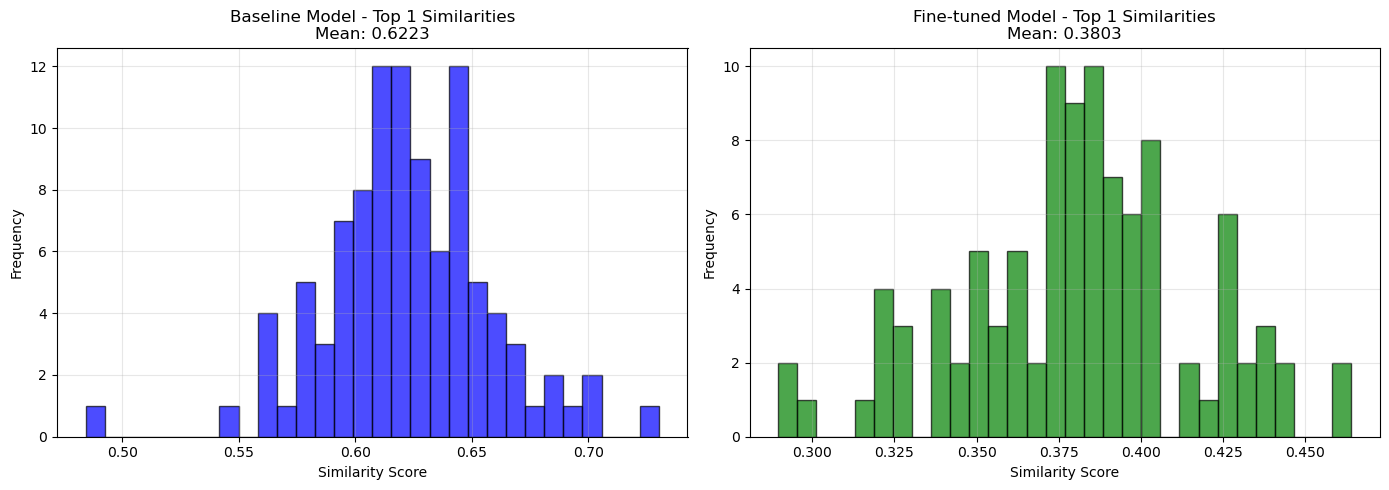


Comparison plot saved to: ../4_model_outputs/finetuned_vs_baseline_comparison.png


In [20]:
# Compare similarity scores
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline model similarities
baseline_top1_sims = baseline_df['top1_similarity']
axes[0].hist(baseline_top1_sims, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Baseline Model - Top 1 Similarities\nMean: {baseline_top1_sims.mean():.4f}')
axes[0].grid(alpha=0.3)

# Fine-tuned model similarities
finetuned_top1_sims = output_df['top1_similarity']
axes[1].hist(finetuned_top1_sims, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Similarity Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Fine-tuned Model - Top 1 Similarities\nMean: {finetuned_top1_sims.mean():.4f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../4_model_outputs/finetuned_vs_baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison plot saved to: ../4_model_outputs/finetuned_vs_baseline_comparison.png")

In [21]:
# Statistical comparison
print("\n" + "="*80)
print("STATISTICAL COMPARISON")
print("="*80)

print(f"\nBaseline Model (all-MiniLM-L6-v2):")
print(f"  Top-1 Similarity - Mean: {baseline_df['top1_similarity'].mean():.4f}")
print(f"  Top-1 Similarity - Std:  {baseline_df['top1_similarity'].std():.4f}")
print(f"  Top-1 Similarity - Min:  {baseline_df['top1_similarity'].min():.4f}")
print(f"  Top-1 Similarity - Max:  {baseline_df['top1_similarity'].max():.4f}")

print(f"\nFine-tuned Model (Job-specific SBERT):")
print(f"  Top-1 Similarity - Mean: {output_df['top1_similarity'].mean():.4f}")
print(f"  Top-1 Similarity - Std:  {output_df['top1_similarity'].std():.4f}")
print(f"  Top-1 Similarity - Min:  {output_df['top1_similarity'].min():.4f}")
print(f"  Top-1 Similarity - Max:  {output_df['top1_similarity'].max():.4f}")

print(f"\nDifference (Fine-tuned - Baseline):")
mean_diff = output_df['top1_similarity'].mean() - baseline_df['top1_similarity'].mean()
print(f"  Mean Similarity: {mean_diff:+.4f}")


STATISTICAL COMPARISON

Baseline Model (all-MiniLM-L6-v2):
  Top-1 Similarity - Mean: 0.6223
  Top-1 Similarity - Std:  0.0361
  Top-1 Similarity - Min:  0.4843
  Top-1 Similarity - Max:  0.7303

Fine-tuned Model (Job-specific SBERT):
  Top-1 Similarity - Mean: 0.3803
  Top-1 Similarity - Std:  0.0357
  Top-1 Similarity - Min:  0.2896
  Top-1 Similarity - Max:  0.4641

Difference (Fine-tuned - Baseline):
  Mean Similarity: -0.2420


## 10. Summary

### Model Configuration
- **Job Descriptions**: Fine-tuned SBERT model (job-matcher_20251121_123928)
- **Resumes**: Base model (all-MiniLM-L6-v2) from basemodel_embedding.ipynb

### Output Format
- Same format as baseline model output
- Top-3 job matches per resume
- Includes similarity scores and job details

### Key Differences from Baseline
- Job embeddings use fine-tuned model trained on job-to-job similarity
- Resume embeddings use the same base model as baseline
- Should show improved job matching accuracy due to domain-specific fine-tuning